<a href="https://colab.research.google.com/github/OmaymaMahjoub/Tweets-Sentimental-Analysis/blob/main/Tweet_Depression_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Depression prediction based on tweets
Finding out if someone is depressed by looking at their tweets.
Sentimental Analysis can be highly helpful in detecting depression and treating it before someone becomes seriously ill.

#Load Dataset:
We have used a kaggle dataset Sentimental analysis for tweets: https://www.kaggle.com/gargmanas/sentimental-analysis-for-tweets 

In [ ]:
from google.colab import files
files.upload()
% cd /content/
# download the dataset
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d gargmanas/sentimental-analysis-for-tweets
! mkdir input
! unzip sentimental-analysis-for-tweets.zip -d input

Saving kaggle.json to kaggle.json
/content
  0% 0.00/476k [00:00<?, ?B/s]
100% 476k/476k [00:00<00:00, 69.9MB/s]
Archive:  sentimental-analysis-for-tweets.zip
  inflating: input/sentiment_tweets3.csv  


#Import Libraries

In [ ]:
!pip install wordcloud
!pip install nltk
import numpy as np
import pandas as pd
import re #Regular expression operations
import seaborn as sns #Visualization
from sklearn.model_selection import train_test_split #split data
import nltk #Natural Language Tool Kit
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import PassiveAggressiveClassifier #first model we use it
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.naive_bayes import MultinomialNB #Second model we use it
from sklearn.ensemble import RandomForestClassifier #Third model we use it
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Data Collection

In [ ]:
twitter=pd.read_csv('/content/input/sentiment_tweets3.csv')

In [ ]:
twitter.head(10)

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
5,624,so sleepy. good times tonight though,0
6,701,"@SilkCharm re: #nbn as someone already said, d...",0
7,808,23 or 24ï¿½C possible today. Nice,0
8,1193,nite twitterville workout in the am -ciao,0
9,1324,"@daNanner Night, darlin'! Sweet dreams to you",0


In [ ]:
twitter.describe()

,Index,label (depression result)
count,10314.000000,10314.000000
mean,491253.470525,0.224355
std,261688.134407,0.417177
min,106.000000,0.000000
25%,263019.250000,0.000000
50%,514988.000000,0.000000
75%,773521.500000,0.000000
max,802313.000000,1.000000


In [ ]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      10314 non-null  int64 
 1   message to examine         10314 non-null  object
 2   label (depression result)  10314 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 241.9+ KB


In [ ]:
twitter.shape

(10314, 3)

so we have 10314 examples

#Feature Engineering
##Data Cleaning

First we need to drop Index column because it won't help us in our model

In [ ]:
twitter=twitter.drop('Index',axis=1)

Remove links

before:

In [ ]:
twitter['message to examine'][2]

'@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zoGfqvh2ME8 '

In [ ]:
for i in range(len(twitter['message to examine'])):
    twitter['message to examine'][i]=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', twitter['message to examine'][i], flags=re.MULTILINE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


After removing links

In [ ]:
twitter['message to examine'][2]

'@comeagainjen  -  '

Remove tags @username

before:

In [ ]:
twitter['message to examine'][2]

'@comeagainjen  -  '

In [ ]:
for p in range(len(twitter['message to examine'])):
    twitter['message to examine'][p]=re.sub('@([a-zA-Z])+','', twitter['message to examine'][p], flags=re.MULTILINE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


After

In [ ]:
twitter['message to examine'][2]

'  -  '

Tweets that contains only numbers

In [ ]:
sum=0
li=[]
for k in range(len(twitter)):
    if twitter['message to examine'][k].isdigit()==True:
        sum+=1
        li.append(k)
sum

2

In [ ]:
li  

[9606, 10313]

In [ ]:
twitter['message to examine'][9606]

'2'

In [ ]:
twitter['message to examine'][10313]

'0'

tweets that are shorter then 6 characters

In [ ]:
su=0
for o in range(len(twitter)):
    if len(twitter['message to examine'][o])<6:
        su+=1
        li.append(o)
su

16

In [ ]:
li

[9606,
 10313,
 2,
 156,
 263,
 809,
 828,
 949,
 2948,
 3477,
 3821,
 5677,
 6395,
 6570,
 7279,
 7707,
 9606,
 10313]

delete the list li that contains the tweets that are only numbers or shorter then 6 characters

In [ ]:
twitter=twitter.drop(index=li)

In [ ]:
twitter.reset_index(inplace=True)

##Overview

In [ ]:
twitter

,index,message to examine,label (depression result)
0,0,just had a real good moment. i missssssssss hi...,0
1,1,is reading manga,0
2,3,Need to send 'em to my accountant tomorrow. O...,0
3,4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
4,5,so sleepy. good times tonight though,0
...,...,...,...
10293,10308,Many sufferers of depression aren't sad; they ...,1
10294,10309,No Depression by G Herbo is my mood from now o...,1
10295,10310,What do you do when depression succumbs the br...,1
10296,10311,Ketamine Nasal Spray Shows Promise Against Dep...,1


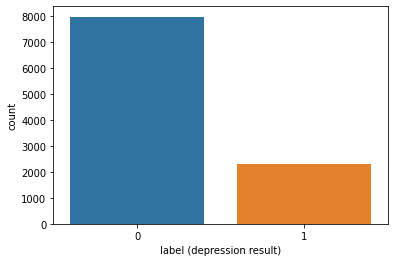

In [ ]:
sns.countplot(x='label (depression result)',data=twitter)

Our data is unbalanced but it's acceptable

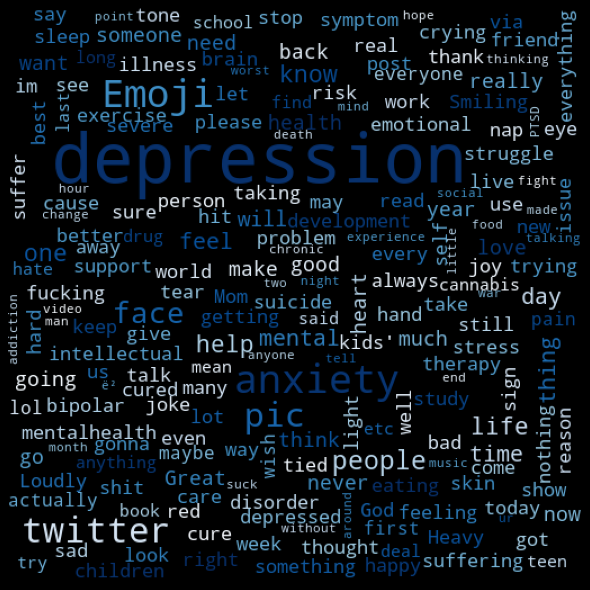

In [ ]:
depressive_words = ' '.join(list(twitter[twitter['label (depression result)'] == 1]['message to examine']))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

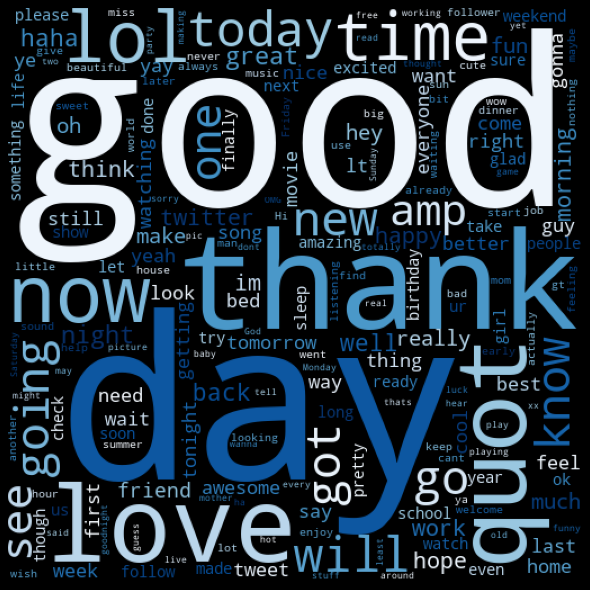

In [ ]:
positive_words = ' '.join(list(twitter[twitter['label (depression result)'] == 0]['message to examine']))
positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

##Split our dataset

####Data preporcessing
We used lemmatizer:
Lemmatization reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma.
For example, runs, running, ran are all forms of the word run, therefore run is the lemma of all these words. Because lemmatization returns an actual word of the language, it is used where it is necessary to get valid words.
We thought also about stemming (remover of suffixes or prefixes) but We thought probably Lemmatization much better 


In [ ]:
lemmatizer = WordNetLemmatizer()
results = []
for i in range(0, len(twitter['message to examine'])):
    review = re.sub('[^a-zA-Z]', ' ', twitter['message to examine'][i])
    review = review.lower()
    review = review.split()
    
    review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    results.append(review)

####Split data
We split our dataset to 15% testing set and 85% training set

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(results, twitter['label (depression result)'], test_size=0.15)

Convert a collection of raw documents to a matrix of TF-IDF features

In [ ]:
cv = TfidfVectorizer(max_features=8000,ngram_range=(1,3))
X_train = cv.fit_transform(X_train).toarray() #Fit to data, then transform it.
X_test=cv.transform(X_test).toarray() #Transform a count matrix to a tf or tf-idf representation.
y_test=np.array(y_test)
y_train=np.array(y_train)

#Training
## Passive Agressive Classifier


In [ ]:
linear_clf = PassiveAggressiveClassifier()

In [ ]:
linear_clf.fit(X_train,y_train)

PassiveAggressiveClassifier()

In [ ]:
y_pred=linear_clf.predict(X_test)

In [ ]:
accuracy_score(y_test,y_pred)

0.996116504854369

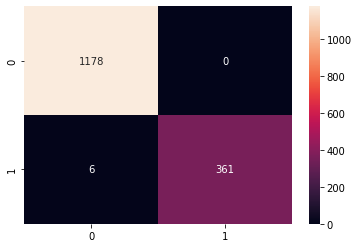

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.4g')

In [ ]:
classification_report(y_test,y_pred)

'              precision    recall  f1-score   support\n\n           0       0.99      1.00      1.00      1178\n           1       1.00      0.98      0.99       367\n\n    accuracy                           1.00      1545\n   macro avg       1.00      0.99      0.99      1545\nweighted avg       1.00      1.00      1.00      1545\n'

##MultinomialNB

In [ ]:
classifier=MultinomialNB()

In [ ]:
classifier.fit(X_train,y_train)
y_np=classifier.predict(X_test)

In [ ]:
accuracy_score(y_test,y_np)

0.9352750809061489

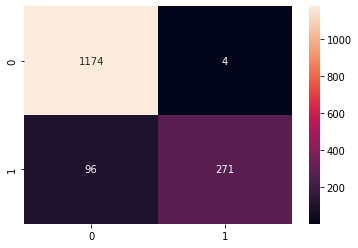

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_np),annot=True,fmt='.4g')

In [ ]:
classification_report(y_test,y_np)

'              precision    recall  f1-score   support\n\n           0       0.92      1.00      0.96      1178\n           1       0.99      0.74      0.84       367\n\n    accuracy                           0.94      1545\n   macro avg       0.95      0.87      0.90      1545\nweighted avg       0.94      0.94      0.93      1545\n'

##Random Forest Classifier

In [ ]:
randomclassifier=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [ ]:
y_predictor=randomclassifier.predict(X_test)

In [ ]:
accuracy_score(y_test,y_predictor)

0.9967637540453075

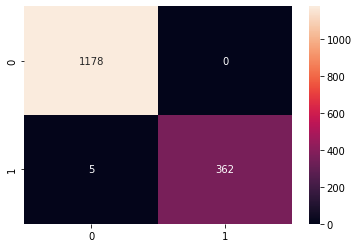

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_predictor),annot=True,fmt='.4g')

In [ ]:
classification_report(y_test,y_predictor)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      1178\n           1       1.00      0.99      0.99       367\n\n    accuracy                           1.00      1545\n   macro avg       1.00      0.99      1.00      1545\nweighted avg       1.00      1.00      1.00      1545\n'

#Build a classifier function
Given a tweet and one of the 3 models we used we can predict if the owner of the tweet have depression or not

In [ ]:
def classing(message, model='Passive Agressive Classifier'):
  #preprocessing the message 
  k=[]
  review = re.sub('[^a-zA-Z]', ' ', message)
  review = review.lower()
  review = review.split()
    
  review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  k.append(review)
  k= cv.transform(k).toarray()
  if model=='Random Forest Classifier':
    result=randomclassifier.predict(k)
  elif model=='Passive Agressive Classifier':
    result=linear_clf.predict(k)
  else:
    result=classifier.predict(k)
  if result[0]==0:
    print("He/She doesn't have depression")
  else:
    print("He/She does have depression")
  return model.predict(k)


In [ ]:
depressed='Hi hello depression and anxiety are the worst'
depressed2='Extreme sadness, lack of energy, hopelessness'
positive='Happy Thursday everyone. Thought today was Wednesday so super happy tomorrow is Friday yayyyyy'

Test using model Passive Agressive Classifier

In [ ]:
k=classing(depressed, model='Passive Agressive Classifier')

In [ ]:
classing(positive, model='Passive Agressive Classifier')

He/She doesn't have depression


Test using model Random Forest Classifier




In [ ]:
classing(depressed, model='Random Forest Classifier')

He/She does have depression


In [ ]:
classing(positive, model='Random Forest Classifier')

He/She doesn't have depression


Test using model MultinomialNB


In [ ]:
classing(depressed, model='MultinomialNB')

He/She does have depression


In [ ]:
classing(positive, model='MultinomialNB')

He/She doesn't have depression


#LSTM

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import re
import keras

In [ ]:
max_features = 8000

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(twitter['message to examine'].values)
X = tokenizer.texts_to_sequences(twitter['message to examine'].values)
X = pad_sequences(X)

Y = pd.get_dummies(twitter['label (depression result)']).values
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X,Y, test_size = 0.15)


In [ ]:
embed_dim = 128
lstm_out = 192

model = Sequential()
model.add(Embedding(8000, embed_dim,input_length = X_train1.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = 'accuracy')
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 70, 128)           1024000   
                                                                 
 spatial_dropout1d_12 (Spati  (None, 70, 128)          0         
 alDropout1D)                                                    
                                                                 
 lstm_12 (LSTM)              (None, 192)               246528    
                                                                 
 dense_12 (Dense)            (None, 2)                 386       
                                                                 
Total params: 1,270,914
Trainable params: 1,270,914
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
import os
checkpoint_path = "/content/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
batch_size = 128
history =model.fit(X_train1, Y_train1, epochs = 3, batch_size=batch_size, validation_split=0.1,callbacks=[cp_callback])

Epoch 1/3
62/62 [==============================] - ETA: 0s - loss: 0.3673 - accuracy: 0.8361
Epoch 00001: saving model to /content/cp.ckpt
62/62 [==============================] - 47s 730ms/step - loss: 0.3673 - accuracy: 0.8361 - val_loss: 0.0927 - val_accuracy: 0.9566
Epoch 2/3
62/62 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.9893
Epoch 00002: saving model to /content/cp.ckpt
62/62 [==============================] - 40s 647ms/step - loss: 0.0370 - accuracy: 0.9893 - val_loss: 0.0192 - val_accuracy: 0.9966
Epoch 3/3
62/62 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9980
Epoch 00003: saving model to /content/cp.ckpt
62/62 [==============================] - 29s 460ms/step - loss: 0.0089 - accuracy: 0.9980 - val_loss: 0.0140 - val_accuracy: 0.9977


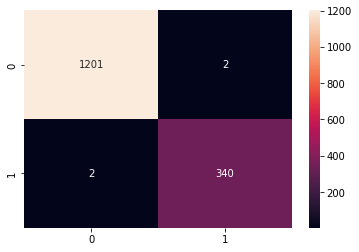

In [ ]:
y_predictor=model.predict(X_test1,batch_size = batch_size)
y_pred=np.argmax(y_predictor, axis=1)
Y_test1=np.argmax(Y_test1, axis=1)
y_pred = (y_pred > 0.5) 

sns.heatmap(confusion_matrix(Y_test1,y_pred),annot=True,fmt='.4g')